In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


ad_data_raw = pd.read_csv('data/AdSmartABdata.csv')

# Some analysis and data cleaning:

In [36]:
ad_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [37]:
ad_data_raw[['yes','no']].sum(axis=1).value_counts()

0    6834
1    1243
dtype: int64

In [38]:
dat = ad_data_raw.copy()
def encode_outcome(row):
    if row['yes']==1:
        return 2
    if row['no']==1:
        return 1
    else: return 0
dat['outcome']=dat.apply(encode_outcome, axis=1)
dat['outcome'].value_counts()

0    6834
1     671
2     572
Name: outcome, dtype: int64

In [39]:
pd.crosstab(dat.experiment,dat.outcome)

outcome,0,1,2
experiment,,,
control,3485,322,264
exposed,3349,349,308


In [40]:
dat['dt'] = pd.DatetimeIndex(dat.date)+pd.to_timedelta(dat.hour, unit='h')

In [41]:
smpl = dat.groupby('experiment').get_group('exposed')
ctrl = dat.groupby('experiment').get_group('control')

## Quick visualization over time:

In [42]:
exp_start = min(pd.DatetimeIndex(dat.date.unique()))
exp_end = max(pd.DatetimeIndex(dat.date.unique()))+pd.to_timedelta(1, unit='d')
experiment_period = pd.date_range(start=exp_start, end=exp_end, freq='H')

<AxesSubplot:>

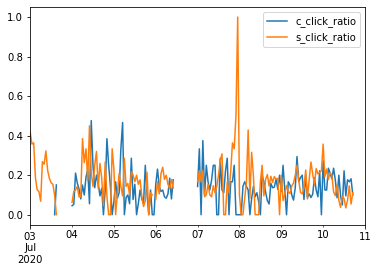

In [43]:
timeseries = pd.DataFrame(index=pd.Series(experiment_period))
# For ctrl
timeseries['c_views'] = ctrl.dt.value_counts()
timeseries[['c_y','c_n']] = ctrl.groupby('dt')[['yes','no']].sum()
timeseries['c_click_ratio']=(timeseries.c_y+timeseries.c_n)/timeseries.c_views
# For smpl
timeseries['s_views'] = smpl.dt.value_counts()
timeseries[['s_y','s_n']] = smpl.groupby('dt')[['yes','no']].sum()
timeseries['s_click_ratio']=(timeseries.s_y+timeseries.s_n)/timeseries.s_views
# click ratio is ratio of clicks to number of auctions in that hour
timeseries[['c_click_ratio','s_click_ratio']].plot()

# Focusing on those who clicked a button:

In [44]:
exposed = smpl[smpl.outcome!=0].drop(['no','outcome'], axis = 1)
control = ctrl[ctrl.outcome!=0].drop(['no','outcome'], axis = 1)
data = dat[dat.outcome!=0].drop(['no','outcome'], axis = 1)

In [45]:
# Calculate conversion rates
mu_exp, mu_con = exposed.yes.mean(), control.yes.mean()
delta_mu = mu_exp - mu_con
mu_exp, mu_con, delta_mu

(0.4687975646879756, 0.45051194539249145, 0.018285619295484168)

In [47]:
dof_exp, dof_con = exposed.shape[0]-1, control.shape[0]-1
dof_exp, dof_con

(656, 585)

## Some Histograms

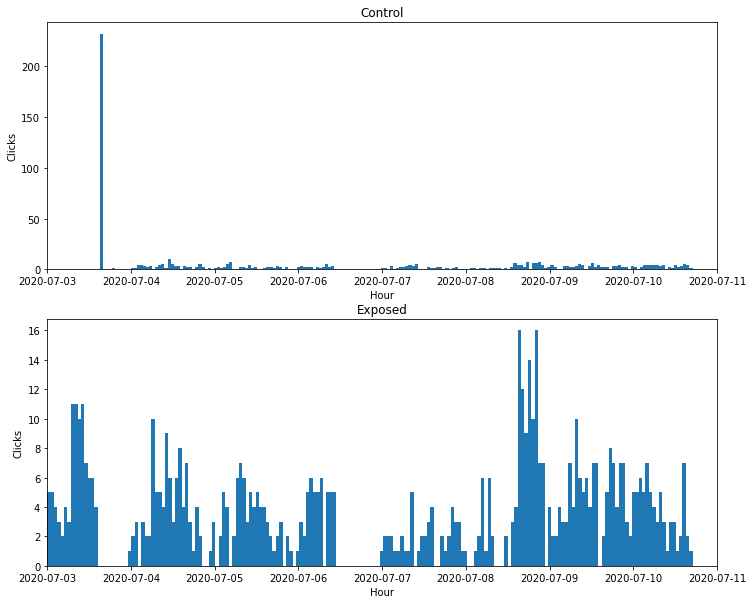

In [48]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211, xlim=[exp_start, exp_end], xlabel='Hour', ylabel='Clicks', title='Control')
ax2 = fig.add_subplot(212, xlim=[exp_start, exp_end], xlabel='Hour', ylabel='Clicks', title='Exposed')
ax1.hist(control.dt, bins=24*8)
ax2.hist(exposed.dt, bins=24*8)
plt.show()

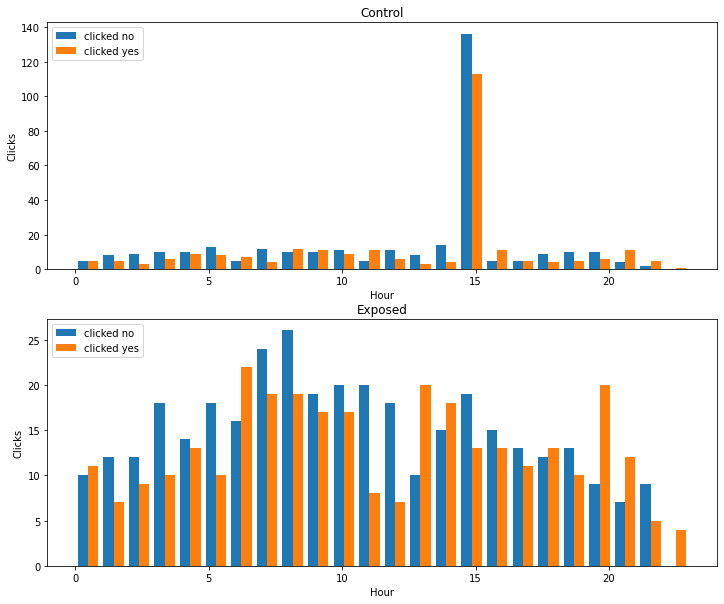

In [49]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211, xlabel='Hour', ylabel='Clicks', title='Control')
ax2 = fig.add_subplot(212, xlabel='Hour', ylabel='Clicks', title='Exposed')
ax1.hist([control[control.yes==0].hour, 
          control[control.yes==1].hour], 
          bins=24,
          label=['clicked no', 'clicked yes'])
ax2.hist([exposed[exposed.yes==0].hour, 
          exposed[exposed.yes==1].hour], 
          bins=24,
          label=['clicked no', 'clicked yes'])
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
plt.show()

## Now testing what changes when the outlier day (7/3) is excluded from the data:

In [50]:
control2 = control[np.array([t.day for t in control.dt]) >= 4]
exposed2 = exposed[np.array([t.day for t in exposed.dt]) >= 4]
data2 = data[np.array([t.day for t in data.dt]) >= 4]

In [51]:
dat2 = dat[np.array([t.day for t in dat.dt]) >= 4]
pd.crosstab(dat2.experiment,dat2.outcome)

outcome,0,1,2
experiment,,,
control,2173,193,160
exposed,2971,300,265


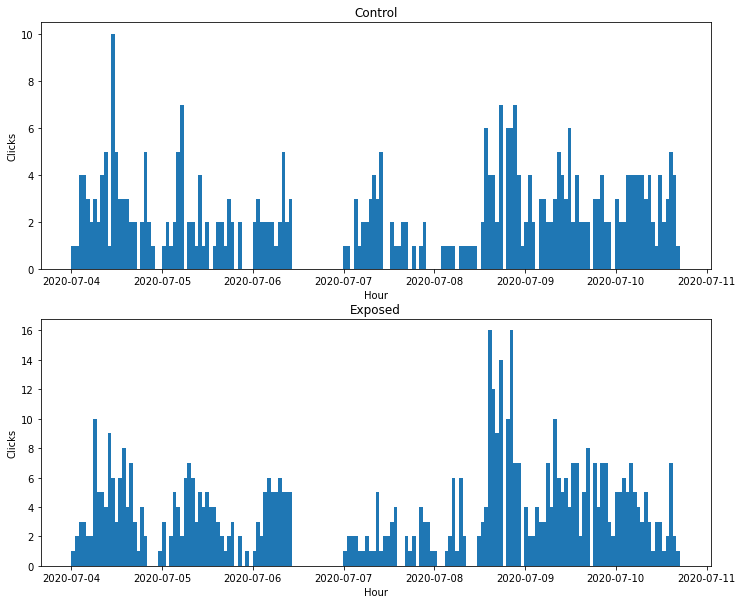

In [52]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211, xlabel='Hour', ylabel='Clicks', title='Control')
ax2 = fig.add_subplot(212, xlabel='Hour', ylabel='Clicks', title='Exposed')
ax1.hist(control2.dt, bins=24*7)
ax2.hist(exposed2.dt, bins=24*7)
plt.show()

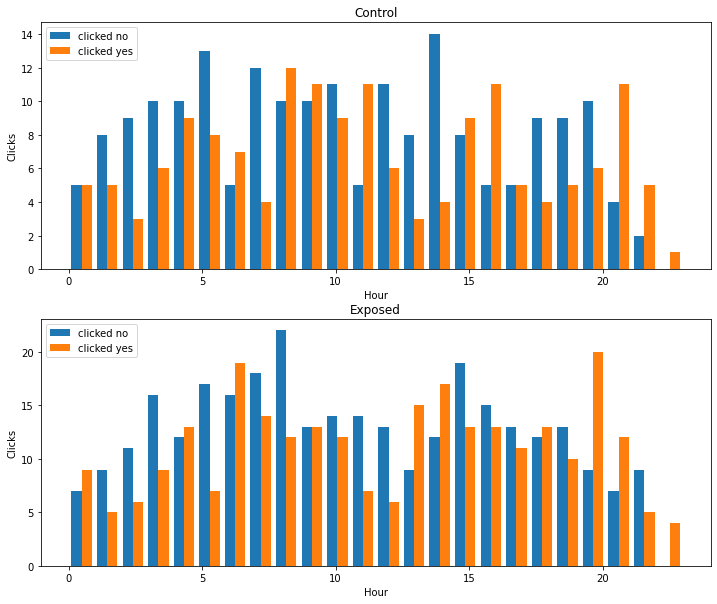

In [53]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211, xlabel='Hour', ylabel='Clicks', title='Control')
ax2 = fig.add_subplot(212, xlabel='Hour', ylabel='Clicks', title='Exposed')

ax1.hist([control2[control2.yes==0].hour, 
          control2[control2.yes==1].hour], 
          bins=24,
          label=['clicked no', 'clicked yes'])
ax2.hist([exposed2[exposed2.yes==0].hour, 
          exposed2[exposed2.yes==1].hour], 
          bins=24,
          label=['clicked no', 'clicked yes'])
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
plt.show()

The data seems to have gotten more reasonable-looking

### Now to see how some statistical values changed after excluding outliers

In [54]:
# Realculate conversion rates
mu_exp, mu_con = exposed2.yes.mean(), control2.yes.mean()
delta_mu2 = mu_exp - mu_con
mu_exp, mu_con, delta_mu2

(0.4690265486725664, 0.45325779036827196, 0.015768758304294417)

In [55]:
dof_exp, dof_con = exposed2.shape[0]-1, control2.shape[0]-1
dof_exp, dof_con

(564, 352)

## Analyzing other categorical variables:

In [56]:
data.columns

Index(['auction_id', 'experiment', 'date', 'hour', 'device_make',
       'platform_os', 'browser', 'yes', 'dt'],
      dtype='object')

In [57]:
all_devices = data.device_make.unique()
all_platforms = data.platform_os.unique()
all_browsers = data.browser.unique()
len(all_devices), len(all_platforms), len(all_browsers)

(115, 2, 8)

In [58]:
def get_common_categ_vals(df, categorical_var, threshold=0.01):
    var_col = df.loc[:,categorical_var]
    composition = var_col.value_counts()/len(var_col)
    return composition[composition>=threshold]

In [59]:
for i,df in enumerate([data, control, control2, exposed, exposed2]):
    dfname = ['all', 'control', 'control2', 'exposed', 'exposed2'][i]
    vals = get_common_categ_vals(df, 'device_make')
    msg = f'{dfname}: {vals.sum()*100:.4f}% of devices are in the top {len(vals.index)} most common devices'
    print(msg)
# it seems the control is skewed towards more common devices

all: 73.6122% of devices are in the top 10 most common devices
control: 80.5461% of devices are in the top 16 most common devices
control2: 81.0198% of devices are in the top 15 most common devices
exposed: 73.2116% of devices are in the top 7 most common devices
exposed2: 73.8053% of devices are in the top 7 most common devices


In [60]:
control3 = control2[np.isin(control2.device_make, get_common_categ_vals(data, 'device_make').index)]
exposed3 = exposed2[np.isin(exposed2.device_make, get_common_categ_vals(data, 'device_make').index)]

In [61]:
dat3 = dat2[np.isin(dat2.device_make, get_common_categ_vals(dat2, 'device_make').index)]
pd.crosstab(dat3.experiment,dat3.outcome)

outcome,0,1,2
experiment,,,
control,1730,138,119
exposed,2132,221,192


In [62]:
# Realculate conversion rates
mu_exp, mu_con = exposed3.yes.mean(), control3.yes.mean()
delta_mu3 = mu_exp - mu_con
mu_exp, mu_con, delta_mu3

(0.4628297362110312, 0.46946564885496184, -0.006635912643930653)

## Hypothesis testing

$$
  \begin{cases}
    H_0:& \mu_{con}=\mu_{exp}\\
    H_1: &\mu_{con}< \mu_{exp}
\end{cases}
$$

$$\text{Where } \mu_{\text{grp}} \text{ is the conversion ratio: } \\
\text{the mean number of 'yes' clicks out of all clicks from group grp} $$

$$\text{Let our alpha level be } \alpha=0.05$$

In [63]:
alpha = 0.05

Now we test for independence of the control and exposed distributions

In [64]:
import scipy.stats as st

In [65]:
t, p = st.ttest_ind(control.yes, exposed.yes, alternative='less', equal_var=False)
t, p

(-0.6453749449008881, 0.2594025104294552)

In [66]:
t, p = st.ttest_ind(control2.yes, exposed2.yes, alternative='less', equal_var=False)
t, p

(-0.4658911349314305, 0.32071450082806574)

In [67]:
t, p = st.ttest_ind(control3.yes, exposed3.yes, alternative='less', equal_var=False)
t, p

(0.1684479164966182, 0.5668538012390318)

None of the iterations of my control and exposed pairs return a p value below my alpha value of 0.05, and thus we fail to reject the null hypothesis. 

So even though the conversion rate for the first two exposed groups are higher than for the corresponding control groups, the difference is not statistically significant, and therefore we cannot conclude that the company is justified in using the new ad.